$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 4: Classification with LDA and Logistic Regression

Daniel Ball

## Overview

Compare LDA and linear and nonlinear logistic regression applied to two data sets.

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn2.tar) and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

as discussed in lecture. 

Write the following functions that train and evaluate LDA and neural network logistic regression models.

* `model = trainLDA(X,T,parameters)`
* `percentCorrect = evaluateLDA(model,X,T)`
* `model = trainNN(X,T,parameters)`
* `percentCorrect = evaluateNN(model,X,T)`
The `parameters` argument for `trainNN` is a list of the hidden layers structure and the number of SCG iterations, as in the previous assignment. The value of the `parameters` argument for `trainLDA` is not used.

Use the `trainValidateTestKFoldsClassification` function in `mlutils.py` to apply the above functions. 

The `NeuralNetworkClassifier` class in the above `neuralnetworks.py` file allows you to specify 0 hidden units.  This creates a neural network with just the output layer designed to do classification.  In other words, specify 0 hidden units to apply linear logistic regression.

In [57]:
import numpy as np
import mlutils as ml
import matplotlib.pyplot as plt
import neuralnetworks as nn
import sys

The following QDA and LDA classes are taken from Professor Chuck Anderson's lecture slides for CS 480 A3 at Colorado State University. They are used to implement the trainLDA function.

In [58]:
import sys # for sys.float_info.epsilon

######################################################################
### class QDA
######################################################################

class QDA(object):
    
    def __init__(self):
        # Define all instance variables here. Not necessary
        self.means = None
        self.stds = None
        self.mu = None
        self.sigma = None
        self.sigmaInv = None
        self.prior = None
        self.determinant = None
        self.discriminantConstant = None

    def train(self, X, T):
        self.classes = np.unique(T)
        self.means, self.stds = np.mean(X,0), np.std(X,0)
        Xs = (X - self.means) / self.stds
        self.mu = []
        self.sigma = []
        self.sigmaInv = []
        self.determinant = []
        self.prior = []
        nSamples = X.shape[0]
        for k in self.classes:
            rowsThisClass = (T == k).reshape((-1))
            self.mu.append( np.mean(Xs[rowsThisClass, :], 0).reshape((-1,1)) )
            self.sigma.append( np.cov(Xs[rowsThisClass, :], rowvar=0) )
            if self.sigma[-1].size == 1:
                self.sigma[-1] = self.sigma[-1].reshape((1,1))
            det = np.linalg.det(self.sigma[-1])
            if det == 0:
                det = sys.float_info.epsilon
            self.determinant.append( det )
            self.sigmaInv.append( np.linalg.pinv(self.sigma[-1]) )    # pinv in case Sigma is singular
            self.prior.append( np.sum(rowsThisClass) / float(nSamples) )
        self._finishTrain()

    def _finishTrain(self):
        self.discriminantConstant = []
        for ki in range(len(self.classes)):
            self.discriminantConstant.append( np.log(self.prior[ki]) - 0.5*np.log(self.determinant[ki]) )

    def use(self,X):
        nSamples = X.shape[0]
        Xs = (X - self.means) / self.stds
        discriminants,probabilities = self._discriminantFunction(Xs)
        predictedClass = self.classes[np.argmax( discriminants, axis=1 )]
        predictedClass = predictedClass.reshape((-1, 1))
        return predictedClass, probabilities, discriminants

    def _discriminantFunction(self, Xs):
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(self.classes)))
        for ki in range(len(self.classes)):
            Xc = Xs - self.mu[ki]
            discriminants[:,ki:ki+1] = self.discriminantConstant[ki] - 0.5 * \
                                       np.sum(np.dot(Xc, self.sigmaInv[ki]) * Xc, axis=1).reshape((-1,1))
        D = Xs.shape[1]
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) )
        return discriminants, probabilities
        
    def __repr__(self):
        if self.mu is None:
            return 'QDA not trained.'
        else:
            return 'QDA trained for classes {}'.format(self.classes)

######################################################################
### class LDA
######################################################################

class LDA(QDA):

    def _finishTrain(self):
        self.sigmaMean = np.sum(np.stack(self.sigma) * np.array(self.prior)[:,np.newaxis,np.newaxis], axis=0)
        self.sigmaMeanInv = np.linalg.pinv(self.sigmaMean)
        # print(self.sigma)
        # print(self.sigmaMean)
        self.discriminantConstant = []
        self.discriminantCoefficient = []
        for ki in range(len(self.classes)):
            sigmaMu = np.dot(self.sigmaMeanInv, self.mu[ki])
            self.discriminantConstant.append( -0.5 * np.dot(self.mu[ki].T, sigmaMu) )
            self.discriminantCoefficient.append( sigmaMu )
    
    def _discriminantFunction(self,Xs):
        nSamples = Xs.shape[0]
        discriminants = np.zeros((nSamples, len(self.classes)))
        for ki in range(len(self.classes)):
            discriminants[:,ki:ki+1] = self.discriminantConstant[ki] + \
                                       np.dot(Xs, self.discriminantCoefficient[ki])
        D = Xs.shape[1]
        probabilities = np.exp( discriminants - 0.5*D*np.log(2*np.pi) - 0.5*np.log(self.determinant[ki]) \
                               - 0.5*np.sum(np.dot(Xs,self.sigmaMeanInv) * Xs, axis=1).reshape((-1,1)))
        return discriminants, probabilities

In [59]:
def trainLDA(X,T,parameters=None):
    lda = LDA()
    lda.train(X,T)
    return lda

def trainNN(X,T,parameters):
    nnet = nn.NeuralNetworkClassifier( X.shape[1], parameters[0], len(np.unique(T)))
    nnet.train(X,T,  nIterations=parameters[1], verbose=False)
    return nnet

def evaluateLDA(model,X,T):
    P_X,Prtrain,_ = model.use(X)
    return 100*np.sum(P_X==T)/len(T)

def evaluateNN(model,X,T):
    P_X = model.use(X)
    return 100*np.sum(P_X==T)/len(T)

## Data
### Abalone 
#### preparation

I'm continuing with my use of <a href="https://archive.ics.uci.edu/ml/datasets/Abalone">abalone data</a> for the first data set. In past assignments, I have attempted to predict age given weight. This time, instead of predicting weight, I'm going to predict "gender". I will replace M F and I with an integer representation: M = 0, F = 1, I = 2.

For review, here is the structure of the abalone data file:
<table>
<tr><th>Name</th> <th>Data Type</th> <th>Meas.</th> <th>Description</th></tr>
<tr><td>Sex				</td><td>nominal	</td><td>		</td><td>M, F, and I (infant)</td></tr>
<tr><td>Length			</td><td>continuous	</td><td>mm		</td><td>Longest shell measurement</td></tr>
<tr><td>Diameter		</td><td>continuous	</td><td>mm		</td><td>perpendicular to length</td></tr>
<tr><td>Height			</td><td>continuous	</td><td>mm		</td><td>with meat in shell</td></tr>
<tr><td>Whole weight	</td><td>continuous	</td><td>grams	</td><td>whole abalone</td></tr>
<tr><td>Shucked weight	</td><td>continuous	</td><td>grams	</td><td>weight of meat</td></tr>
<tr><td>Viscera weight	</td><td>continuous	</td><td>grams	</td><td>gut weight (after bleeding)</td></tr>
<tr><td>Shell weight	</td><td>continuous	</td><td>grams	</td><td>after being dried</td></tr>
<tr><td>Rings			</td><td>integer	</td><td>		</td><td>+1.5 gives the age in years</td></tr>
</table>

In [60]:
# load abalone data. Replace M/F/I with 1/2/3
def sexCheck(sex):
    if ord(sex) == ord('M'):
        return 1
    if ord(sex) == ord('F'):
        return 2
    if ord(sex) == ord('I'):
        return 3
    return 0

abaloneData = np.loadtxt('abalone.data',delimiter=',', converters={0: sexCheck})

Now we need to divide this into data and target vectors.

In [ ]:
# Separate data into trait (X) and target (T)
abaloneX = abaloneData[:, 1:]  #data is all columns starting at 1
abaloneT = abaloneData[:, 0:1] #classes are in colum 0

In [280]:
abaloneNames = ['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Rings']

#### Relational Observations
Here we examine the relationship between the input traits and the categories (M/F/I). We do this by plotting category vs traits and seeing if there are any obvious trends. To achieve this, I will create a histogram for whole weight, age, height, and width, similar to the histogram from A3. Now though, rather than using the histogram to observe the shape of the distribution, we wish to see if the centers of the distributions are different for each trait. If they are, there should be a good correlation from those traits to their gender and thus be useful for classification.

In [63]:
# function for creating a histogram subplot
def plotHist(M,F,I, col, xLabel, plotNum):
    plt.subplot(3,3,plotNum)
    plt.hist(M[:,col], histtype='bar', alpha=0.40, bins=30, label='male')
    plt.hist(F[:,col], histtype='bar', alpha=0.40, bins=30, label='female')
    plt.hist(I[:,col], histtype='bar', alpha=0.40, bins=30, label='infant')
    plt.xlabel(xLabel)
    plt.ylabel('count')
    plt.legend(loc='upper right')

In [64]:
# split X into M,F,I submatrices    
abaloneM = abaloneX[abaloneT[:,0] == 1]
abaloneF = abaloneX[abaloneT[:,0] == 2]
abaloneI = abaloneX[abaloneT[:,0] == 3]

In [65]:
plt.figure(figsize=(30,30))
for i, name in enumerate(abaloneNames):
    plotHist(abaloneM, abaloneF, abaloneI, i, name, i+1)
plt.show()

One point that stands out is that infants are nearly always separated from both male and female; for obvious reasons: they will be both younger and smaller, so all measurements will be lower for this category. Males and females have differences, but many of their traits are still fairly well aligned, to the point I think only a few traits will be particularly useful in classifying them. In particular females appear to live slightly longer on average and be slightly larger. Unfortunately, I don't believe these differences are large enough. I expect the classification to have a high degree of uncertainty in identifying male vs. female as opposed to adult vs. infant. There also appear to be some outliers that have badly affected the shape of the height plot, but I believe the graph is adequate.

### Ground Cover
The second data set will be <a href="https://archive.ics.uci.edu/ml/datasets/Covertype">cover type data</a>, which categorizes the type of foliage over geographical regions. This is a fairly large set of data. There are 12 traits overall, but wilderness area and soil type are segmented into 4 indicator values and soil type is distributed into 40 inidicator values. The cover type is the value which we seek to predict, an integral representation from 1 to 7. Data is arranged as follows within the file:
<pre>
Name                                     Data Type    Measurement                       Description

Elevation                               quantitative    meters              Elevation in meters
Aspect                                  quantitative    azimuth             Aspect in degrees azimuth
Slope                                   quantitative    degrees             Slope in degrees
Horizontal_Distance_To_Hydrology        quantitative    meters              Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology          quantitative    meters              Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways         quantitative    meters              Horz Dist to nearest roadway
Hillshade_9am                           quantitative    0 to 255 index      Hillshade index at 9am, summer solstice
Hillshade_Noon                          quantitative    0 to 255 index      Hillshade index at noon, summer soltice
Hillshade_3pm                           quantitative    0 to 255 index      Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points      quantitative    meters              Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns)      qualitative     binary              Wilderness area designation
Soil_Type (40 binary columns)           qualitative     binary              Soil Type designation
Cover_Type (7 types)                    integer         1 to 7              Forest Cover Type designation
</pre>
The last column is cover type, our target. It is divided into seven classes:
<pre>       
1 -- Spruce/Fir
2 -- Lodgepole Pine
3 -- Ponderosa Pine
4 -- Cottonwood/Willow
5 -- Aspen
6 -- Douglas-fir
7 -- Krummholz
</pre>


In [66]:
coverData = np.loadtxt('covtype.data',delimiter=',')

In [67]:
# separate into traits (X) and targets (T)
coverX = coverData[:,:-1]
coverT = coverData[:,-1:]

In [68]:
print("coverXtrain shape: {}".format(coverXtrain.shape))
print("coverTtrain shape: {}".format(coverTtrain.shape))
print("coverXtest shape:  {}".format(coverXtest.shape))
print("coverTtest shape:  {}".format(coverTtest.shape))

coverXtrain shape: (464810, 54)
coverTtrain shape: (464810, 1)
coverXtest shape:  (116202, 54)
coverTtest shape:  (116202, 1)


#### Relational Observations
This is somewhat more difficult to examine than the abalone data due to the large number and variety of inputs. Ground cover is currently in a boolean value for each type. Instead, I will condense this to an integer representation in a single column and plot the value against the cover type for each data point. 
Each row contains values in this order and count: [Continuous(6)][Discrete(3)][Continuous(1)][Binary(4)][Binary(40]. First we'll create some sub-arrays of the data for display, grouping binary column sets into integer representations.

In [69]:
soilX = coverX[:,-40:]

In [70]:
np.where(soilX[0]==1)

(array([28], dtype=int64),)

In [71]:
soilTypes = [np.where(soilX[i]==1)[0][0] + 1 for i in range(soilX.shape[0])]
soilTypes = np.array(soilTypes)
soilTypes = np.expand_dims(soilTypes, axis=1)
np.unique(soilTypes) # check the value range

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40], dtype=int64)

In [72]:
soilTypes

array([[29],
       [29],
       [12],
       ..., 
       [ 2],
       [ 2],
       [ 2]], dtype=int64)

In order to give an indication of how many points are , we will add a small random dither to the values to indicate the density of points. 

In [73]:
coverDither = np.expand_dims(np.random.uniform(-.1,.1,soilTypes.shape[0]), axis=1)
ditheredCover = coverDither + coverT
ditheredCover.squeeze()

array([ 4.93065159,  4.94786577,  1.90892412, ...,  2.97307468,
        2.98074058,  2.94862991])

In [74]:
soilDither = np.expand_dims(np.random.uniform(-.2,.2,soilTypes.shape[0]), axis=1)
ditheredSoil = soilDither + soilTypes
ditheredSoil.squeeze()

array([ 28.86438169,  28.91960173,  12.05513264, ...,   1.88640195,
         1.84310015,   1.89922733])

Now reshape and plot

In [75]:
def plotScatteredDither(X, Y, xlabel, ylabel, xlim):
    fig = plt.figure(figsize=(10,5))
    plt.xlim(xlim)
    #hide ticks for 0 and 8
    ax = fig.add_subplot(111)
    ax.scatter(X, Y, alpha=0.1)
    yticks = ax.yaxis.get_major_ticks()  
    yticks[0].label1.set_visible(False)
    yticks[-1].label1.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

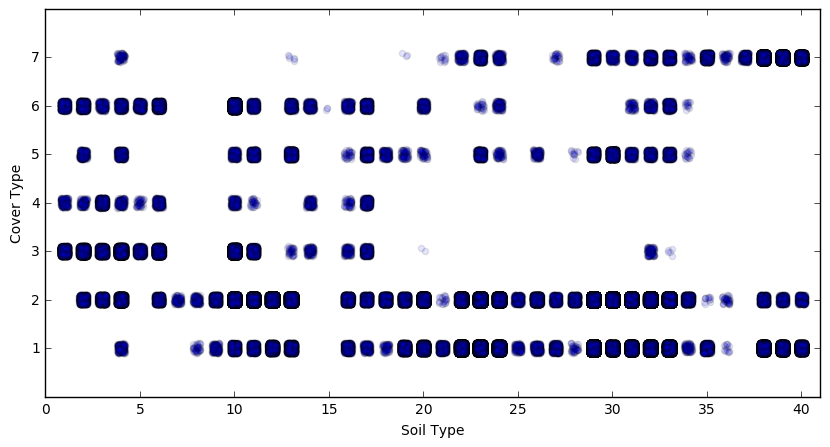

In [76]:
plotScatteredDither(ditheredSoil, ditheredCover, 'Soil Type', 'Cover Type', (0,41))

Here we can see that while there is certainly overlap in traits for each cover type, it is apparent that soil type may be a good indicator. This appears to be particularly true for cover types 7, 4, and 3, which are only viable on less than half of the soil types in the data.

Now a similar plot for the wilderness area the sample belongs to. This is essentially a geographical trait which I believe encompasses a large number of factors, particularly with regards to climate (temperature, rainfall, humidity, etc.)

In [77]:
# convert indicator values to integer range
wildernessX = coverX[:,-44:-40]
wildernessX = [np.where(wildernessX[i]==1)[0][0] + 1 for i in range(wildernessX.shape[0])]
wildernessX = np.array(wildernessX)
np.unique(wildernessX)

array([1, 2, 3, 4], dtype=int64)

In [78]:
# add dither
wildDither = np.expand_dims(np.random.uniform(-.3,.3,wildernessX.shape[0]), axis=1)
wildDither.shape, wildernessX.shape

((581012, 1), (581012,))

In [79]:
wildDither = wildDither.squeeze()

In [80]:
coverDither = np.expand_dims(np.random.uniform(-.3,.3,soilTypes.shape[0]), axis=1)
ditheredCover = coverDither + coverT

In [81]:
ditheredWild = wildDither + wildernessX

In [82]:
plotScatteredDither(ditheredWild, ditheredCover, 'Wlderness Area', 'Cover Type', (0,5))

Here too we see that the wilderness area has an effect on the cover type. While wilderness area 3 has all but cover type 4, the other 3 wilderness areas appear to have a relatively restricted biosphere. This will be particularly useful in identifying cover type 4, since it is only extant in wilderness area 4, and reasonably useful for cover types 6, 5, and 3 since they can only be found in two areas.

For the remaining quantitative values, I will again turn to histograms. I will use lines rather than bars, with one line for each cover type. Areas where one cover dominates the histogram should be good indicators for that cover type. First create a list of data, where the cover type for the associated data is one greater than the index int he list.

In [83]:
coverNames = ['Spruce/Fir',
                'Lodgepole Pine',
                'Ponderosa Pine',
                'Cottonwood/Willow',
                'Aspen',
                'Douglas-fir',
                'Krummholz']
coverSet = []
for i, coverName in enumerate(coverNames):
    name = coverNames[i]
    data = coverX[(coverT[:,0] == i+1)]
    coverSet.append({'name': name, 'data': data})

In [84]:
for entry in coverSet:
    print(entry['name'], ': ', len(entry['data'][:,0]))

Spruce/Fir :  211840
Lodgepole Pine :  283301
Ponderosa Pine :  35754
Cottonwood/Willow :  2747
Aspen :  9493
Douglas-fir :  17367
Krummholz :  20510


Now we have segmented the data categorically so we can plot a hisogram for each cover type.

In [85]:
traits = [
    'Elevation',                               
    'Aspect',                                  
    'Slope',                                   
    'Horizontal_Distance_To_Hydrology',        
    'Vertical_Distance_To_Hydrology',          
    'Horizontal_Distance_To_Roadways',         
    'Hillshade_9am',                           
    'Hillshade_Noon',                          
    'Hillshade_3pm',                           
    'Horizontal_Distance_To_Fire_Points'      
    ]

In [86]:
coverSet[0]['data'][:,0] #verify the correct access pattern for a column

array([ 2699.,  2739.,  2696., ...,  2812.,  2832.,  2827.])

Note that the histograms are normalized (normed=True). This is because, as seen above, the proportions of entries per cover type are not proportional. By normalizing, we can see how each trait affects the cover type as a percentage without any one type dominating the entire plot.

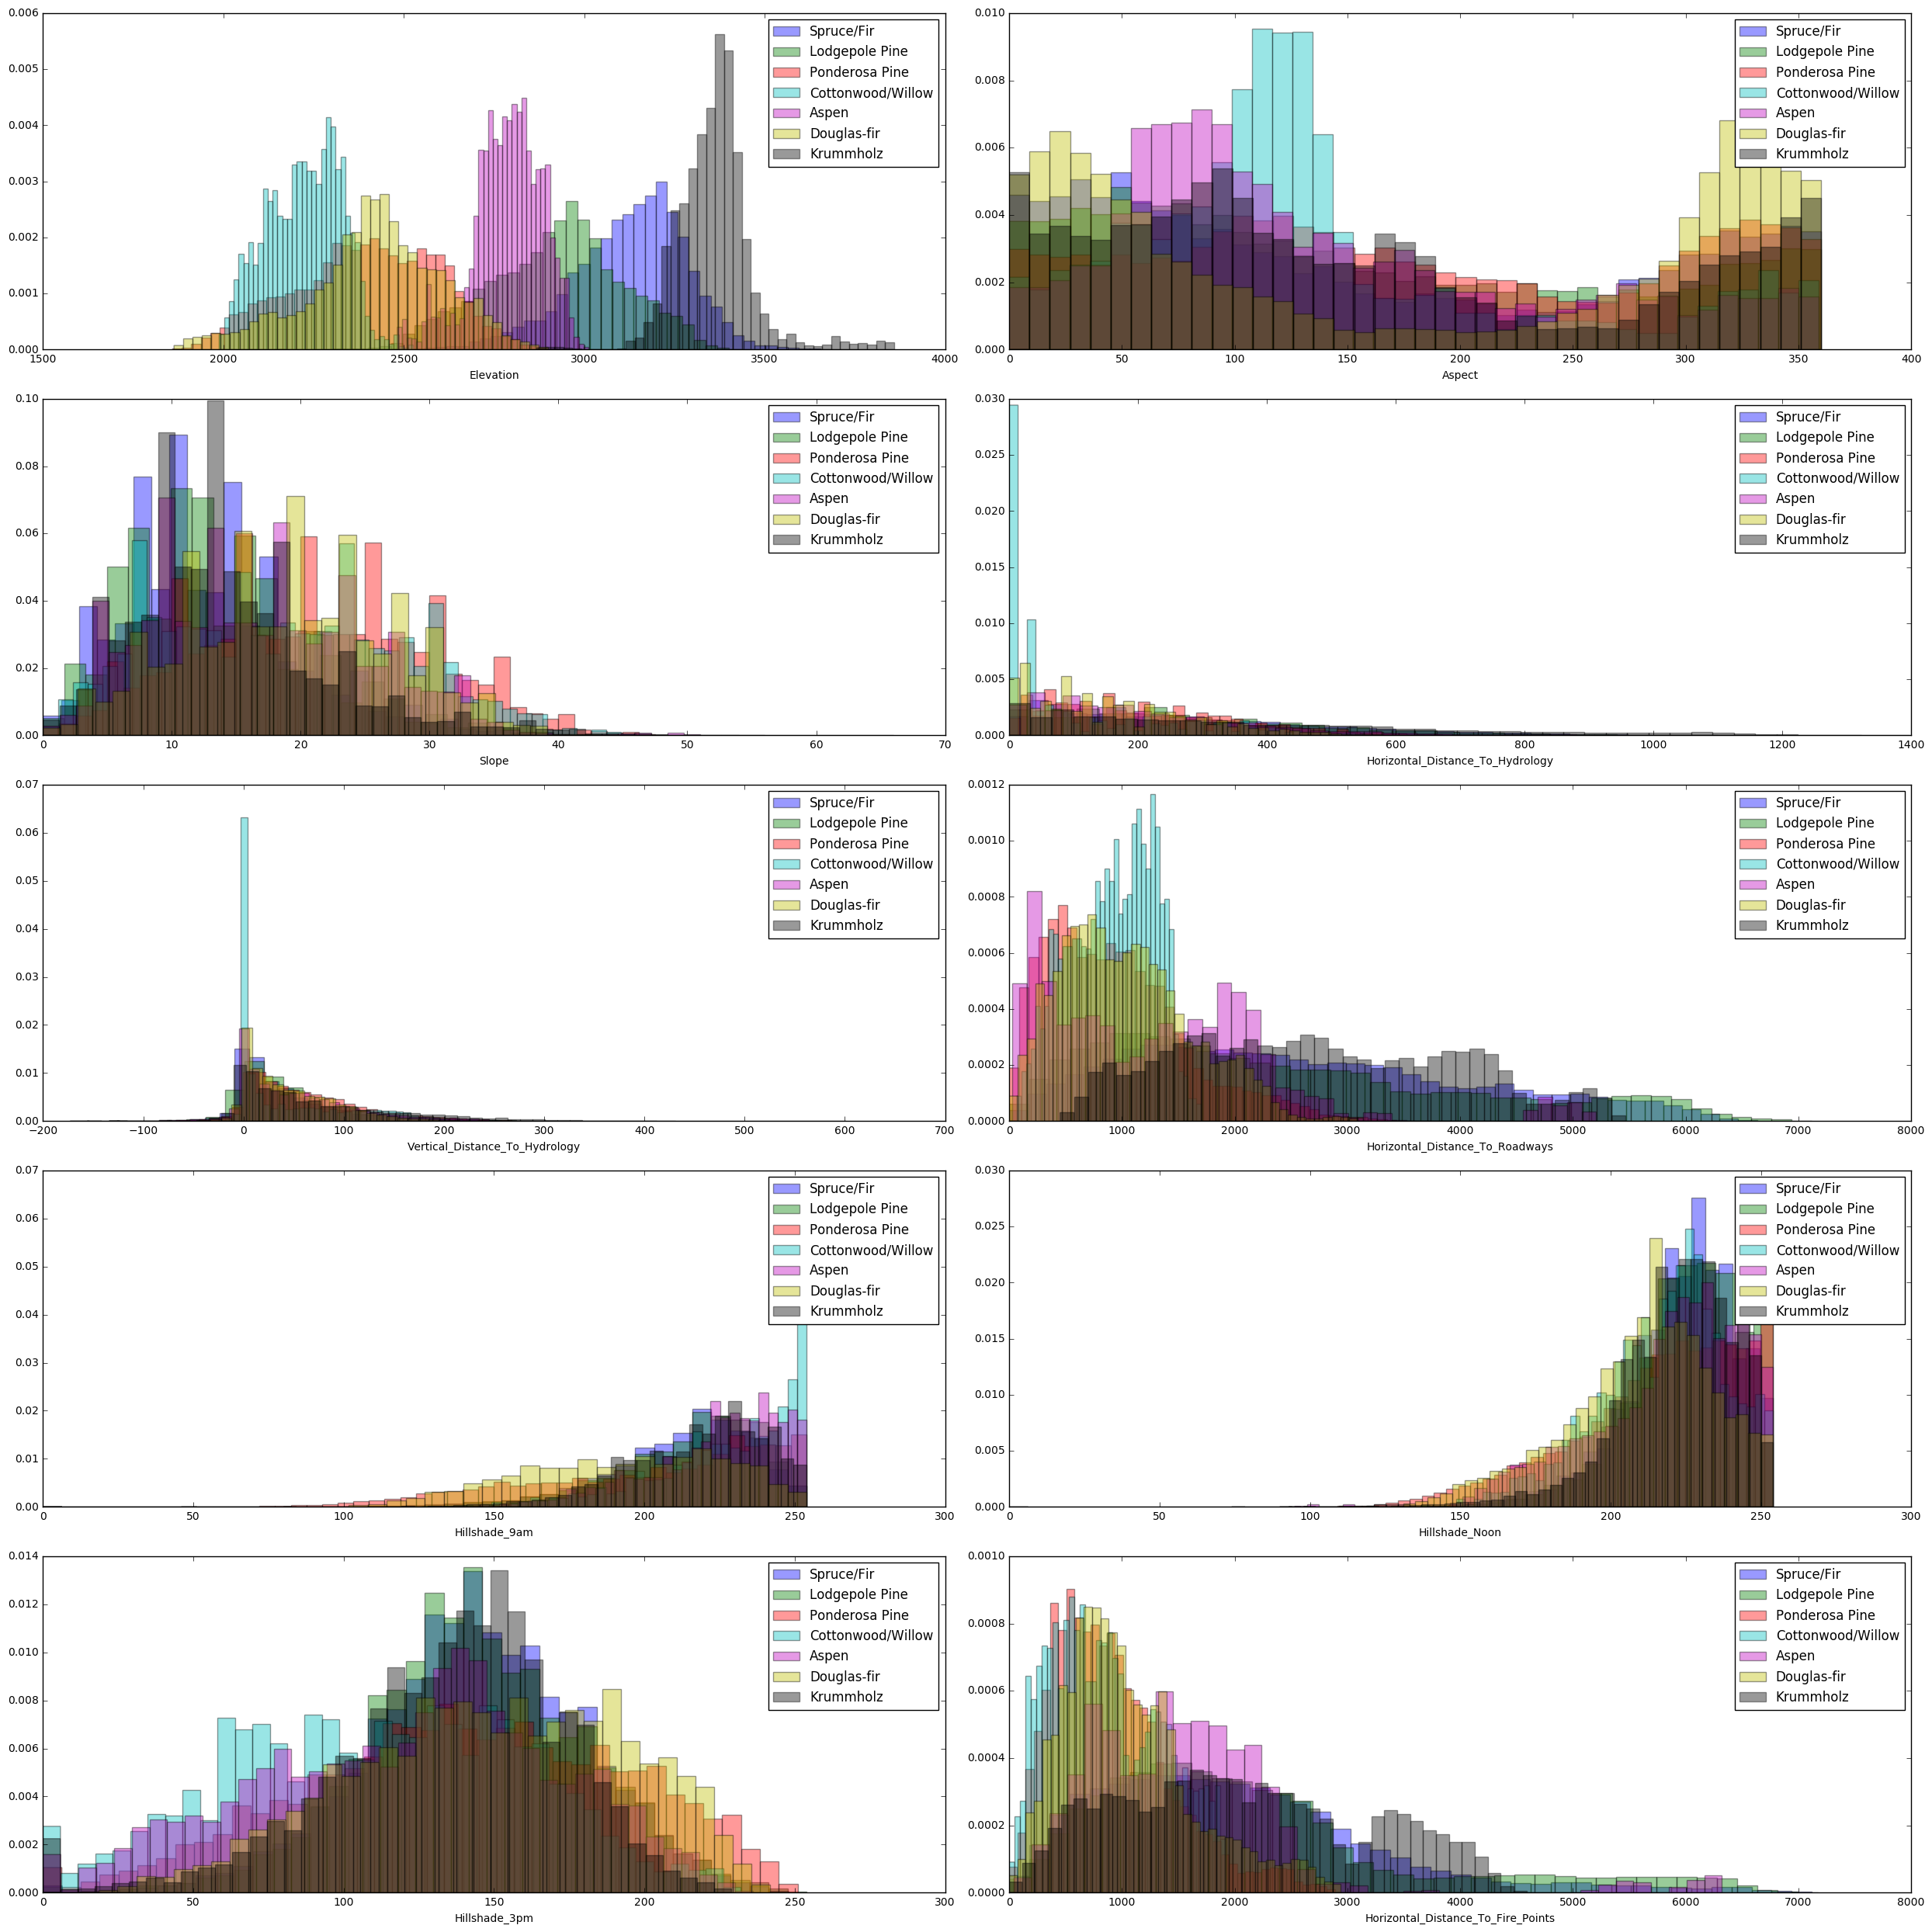

In [87]:
plt.figure(figsize=(25,25))
for i, trait in enumerate(traits): # make a subplot for each quantitative trait
    for cover in coverSet: # add a line to the histogram for each cover type
        plt.subplot(5,2,i+1)
        plt.hist(cover['data'][:,i], normed=True, histtype='bar', alpha=0.40, bins=40, label=cover['name'])
        plt.xlabel(trait)
        plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

A few plots stand out. The biggest is elevation, which appears to have a tremendous impact on the cover type. Aspect (cardinal direction a slope faces) appears to play a large part as well. I would expect this to do with the amount of shade received, but this does not appear to correspond as much as I would expect. Perhaps it is more related to the amount of precipitation a face receives. Other contenders are distance to roadwas and distance to fire points. These don't look to be as prominently distributed, but they do seem to have a few cover types which dominate particular regions. One other point of note is the distance to hydrology. Cottonwood and willow seem to be fairly exclusive to regions with nearly adjacent water. This is reasonable since, in my experience, I rarely see a cottonwood far from a water source of some kind; near ponds, rivers, or irrigation. I think slope may also have an interesting effect; it appears to have some fairly tall 'spikes" in the plot which may make good indicators for a particular cover type.

## Results
Here we discuss the functions developed and apply them to the data. We then evaluate the methods when applied to different data sets. 

### Function descriptions
Following are descriptions of the four functions used to attempt to create a useful classification model.

#### trainNN(X,T,parameters)
This function creates a classifier neural network, then trains it using the provided data(X) and targets (T). The neural network code was provided by the professor. The number of inputs is equal to the width of X and the number of outputs is equal to the number of unique classes in T. The shape of the network is provided in parameters, as is the number of iterations to be performed during training.

#### evaluateNN()
This function evaluates the neural net with the provided input data (X) and returns the percentage of accurate predictions against the targets (T). It does this by calling the "use" method of the model.

#### trainLDA()
This function uses the LDA class to train a linear discriminant analysis model and returns the class as the model. The discriminant function for LDA is: $ \delta_k(\xv) = \xv^T \Sigmav^{-1} \muv_k - \frac{1}{2}\muv_k^T \Sigmav^{-1} \muv_k + \log P(C=k) $. For a given input, whichever class has a highest result from the discriminant function is considered to be the most likely and used as the prediction.

#### evaluateLDA()
This function evaluates the LDA via the use() method and returns the percentage of accurate predictions.

### Experiments
Here I apply the functions to the data analyzed earlier. I will attempt multiple variations in training to attempt to find the best model both for neural network and linear discriminant analysis methods.

#### Abalone
First, I will use linear logistic regression by specifying 0 hidden layers to the neural network for training. Using this, I will isolate a best case baseline by trying to find the best accuracy generated by the linear regression model. I will use this baseline for comparison to the LDA and neural network classifier models.

In [220]:
def prettyPrintResults(results):
    print("{:>20}{:^45}".format('','Accuracy'))
    print("{:<20}{:^15}{:^15}{:^15}".format('Parameters', 'Train %', 'Validate %', 'Test %'))
    for result in results:
        params, train, val, test = result
        print("{:<20}{:^15.2f}{:^15.2f}{:^15.2f}".format(str(params), train, val, test))    

In [196]:
abaloneCoarseParams = [
    [ [0], 10],
    [ [0], 100],
    [ [0], 1000]
]
result = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams,
                                         nFolds=5, shuffle=True,verbose=False)

In [197]:
prettyPrintResults(result)

                                 Accuracy                   
Parameters         Train %      Validate %       Test %     
[[0], 1000]         65.71          63.63          75.63     
[[0], 100]          67.43          64.54          71.89     
[[0], 10]           68.84          65.59          68.37     
[[0], 10]           69.81          67.30          61.59     
[[0], 1000]         70.97          69.40          53.23     


From this we see that linear regression appears to reach an optimal of near 72% with 100 iterations. From here let's examine around 100 iterations to try to pinpoint a good value.

In [198]:
abaloneLinLogParams = [
    [ [0], 50],
    [ [0], 100],
    [ [0], 150]
]
result = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneLinLogParams,
                                         nFolds=5, shuffle=True,verbose=False)
prettyPrintResults(result)


                                 Accuracy                   
Parameters         Train %      Validate %       Test %     
[[0], 100]          65.61          62.94          76.52     
[[0], 50]           67.39          64.02          73.54     
[[0], 100]          69.13          65.21          68.00     
[[0], 100]          70.07          66.69          61.50     
[[0], 100]          71.38          69.86          49.16     


It looks like 100 iterations is still pretty good ... now we will add a few folds to try to see what the peak accuracy is.

In [199]:
abaloneCoarseParams = [ [ [0], 100]]
result = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams,
                                         nFolds=8, shuffle=True,verbose=False)
prettyPrintResults(result)


                                 Accuracy                   
Parameters         Train %      Validate %       Test %     
[[0], 100]          73.12          69.94          82.13     
[[0], 100]          73.80          70.33          79.07     
[[0], 100]          74.22          70.15          77.61     
[[0], 100]          74.48          70.42          76.23     
[[0], 100]          74.86          70.85          73.15     
[[0], 100]          75.11          71.37          68.76     
[[0], 100]          75.45          72.20          63.11     
[[0], 100]          75.86          73.90          49.91     


##### LDA
First we want to find the optimal LDA.

In [203]:
resultLDA = ml.trainValidateTestKFoldsClassification( trainLDA,evaluateLDA, abaloneX,abaloneT, [[]], nFolds=30, shuffle=True,verbose=False)

In [204]:
prettyPrintResults(resultLDA)

                                 Accuracy                   
Parameters         Train %      Validate %       Test %     
[]                  82.66          79.63          86.06     
[]                  82.72          79.65          86.13     
[]                  82.66          79.64          86.12     
[]                  82.82          79.79          85.34     
[]                  82.83          79.74          85.78     
[]                  82.95          79.80          84.86     
[]                  82.88          79.70          84.88     
[]                  82.84          79.73          85.18     
[]                  82.60          79.62          84.58     
[]                  82.79          79.63          84.50     
[]                  82.79          79.78          84.32     
[]                  82.92          79.87          84.44     
[]                  82.96          79.85          82.80     
[]                  82.65          79.72          82.73     
[]                  82.9

It is interesting to note that a the lower validation accuracies correspond to higher test accuracies.

##### Neural Network Classifier
And now the neural network. First a coarse evaluation to attempt to find a good hidden layer shape, then a fine evaluation to isolate the best model.

In [208]:
abaloneCoarseParams = []
for layers in [1,2,3]:
    for size in [5,10,15]:
        for iters in [50,100,500]:
            abaloneCoarseParams.append([[size for i in range(layers)], iters])

In [222]:
abaloneCoarseParams

[[[5], 50],
 [[5], 100],
 [[5], 500],
 [[10], 50],
 [[10], 100],
 [[10], 500],
 [[15], 50],
 [[15], 100],
 [[15], 500],
 [[5, 5], 50],
 [[5, 5], 100],
 [[5, 5], 500],
 [[10, 10], 50],
 [[10, 10], 100],
 [[10, 10], 500],
 [[15, 15], 50],
 [[15, 15], 100],
 [[15, 15], 500],
 [[5, 5, 5], 50],
 [[5, 5, 5], 100],
 [[5, 5, 5], 500],
 [[10, 10, 10], 50],
 [[10, 10, 10], 100],
 [[10, 10, 10], 500],
 [[15, 15, 15], 50],
 [[15, 15, 15], 100],
 [[15, 15, 15], 500],
 [[5, 2, 5], 50],
 [[10, 5, 10], 50],
 [[10, 5, 3], 50],
 [[5, 2, 5], 100],
 [[10, 5, 10], 100],
 [[10, 5, 3], 100],
 [[5, 2, 5], 500],
 [[10, 5, 10], 500],
 [[10, 5, 3], 500],
 [[5, 2, 5], 10],
 [[10, 5, 10], 10],
 [[10, 5, 3], 10],
 [[5, 2, 5], 50],
 [[10, 5, 10], 50],
 [[10, 5, 3], 50],
 [[5, 2, 5], 100],
 [[10, 5, 10], 100],
 [[10, 5, 3], 100]]

In [215]:
for iters in [10,50,100]:
    for shape in [[5,2,5],[10,5,10],[10,5,3]]:
        abaloneCoarseParams.append([shape, iters ])

In [217]:
# abaloneResultNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams, nFolds=5, shuffle=True,verbose=False)
# prettyPrintResults(abaloneResultNN)

That took a long time, here's a record so I don't have to run it again; I've left the code commented:
<pre>
                                        Accuracy                   
Parameters              Train %      Validate %       Test %     
[[15, 15], 500]          75.10          66.97          76.15     
[[15, 15, 15], 500]      74.10          66.88          75.67     
[[15, 15], 500]          73.36          68.24          70.55     
[[15], 500]              73.56          69.51          64.67     
[[15, 15], 500]          76.33          72.02          53.83   
</pre>
This shows that a constant value for hidden layers seems best, and the largest number of iterations. Unfortunately, this is the limit of what i tested so I'll need to do some larger values as well. It's also worth noting that the difference between values seems somewhat arbitrary; it's likely that I simply haven't found a sweet spot. I'll start by trying a one of each at 1000 iterations. If that doesn't improve much past the 76% peak, I'll know there's not much point in trying further.

In [233]:
abaloneCoarseParams = []
for layers in [2,3]:
    for size in [15, 60]:
        for iters in [1000]:
            abaloneCoarseParams.append([[size for i in range(layers)], iters])
abaloneCoarseParams

[[[15, 15], 1000],
 [[60, 60], 1000],
 [[15, 15, 15], 1000],
 [[60, 60, 60], 1000]]

In [234]:
# abaloneResultNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams, nFolds=4, shuffle=True,verbose=False)
# prettyPrintResults(abaloneResultNN)

Well that took an hour to run and it's not really any better than at 500. Once again for posterity, the output from above:
<pre>
                                      Accuracy                   
Parameters              Train %      Validate %       Test %     
[[60, 60], 1000]         92.08          66.10          74.83     
[[60, 60], 1000]         95.51          65.94          76.33     
[[60, 60], 1000]         94.07          69.66          68.99     
[[60, 60], 1000]         96.00          72.27          62.30  
</pre>
It is still decidedly favoring a larger hidden layer size. So let's try one more at 500 with some larger layer sizes:

In [238]:
abaloneCoarseParams = []
for size in [60, 100, 200]:
    abaloneCoarseParams.append([[size for i in range(2)], 500])
abaloneCoarseParams

[[[60, 60], 500], [[100, 100], 500], [[200, 200], 500]]

In [239]:
# abaloneResultNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams, nFolds=4, shuffle=True,verbose=False)
# prettyPrintResults(abaloneResultNN)

Once again the output of the above commented code for posterity:
<pre>
                                      Accuracy                   
Parameters              Train %      Validate %       Test %     
[[100, 100], 500]        76.30          65.56          71.66     
[[60, 60], 500]          79.44          65.05          72.30     
[[200, 200], 500]        78.65          66.89          66.01     
[[60, 60], 500]          78.23          70.49          58.37    
</pre>

It seems that 200 is too large but I think there might be a sweet spot between 100 and 60, so I'll check between them.

In [242]:
abaloneCoarseParams = []
for size in [80]:
    abaloneCoarseParams.append([[size for i in range(2)], 500])
abaloneCoarseParams

[[[80, 80], 500]]

In [251]:
# abaloneResultNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, abaloneX,abaloneT, abaloneCoarseParams, nFolds=4, shuffle=True,verbose=False)
# prettyPrintResults(abaloneResultNN)

<pre>
                                      Accuracy                   
Parameters              Train %      Validate %       Test %     
[[80, 80], 500]          75.48          64.92          71.61     
[[80, 80], 500]          77.99          64.16          73.29     
[[80, 80], 500]          78.40          67.06          66.88     
[[80, 80], 500]          77.40          70.18          57.42  
</pre>
It seems that anywhere in the range of 50-100 works reasonably well. So i will use hidden layers of [50,50]. 

##### Comparison of methods
From the results obtained, it appears that neither the LDA model or a neural network classifier performed significantly better than a linear logistic regression. There were some LDA test sets which resulted in a higher accuracy than LLR, but by a small margin. This is unsurprising since during the analysis of the data it was noted that there is a very large overlap between male and female abalone on all of the measurements provided. It is likely that the reason accuracy was even as high as it was is due to the infant abalone being somewhat easier to classify. Let's take a look at that.

In [ ]:
abaloneXTrain,abaloneTTrain,abaloneXTest,abaloneTTest = ml.partition(abaloneX,abaloneT,(.8,.2),classification=True)
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[60,60], 500])

In [ ]:
abaloneLDAModel = trainLDA(abaloneXTrain, abaloneTTrain)

In [255]:
abaloneLinLogModel = trainNN(abaloneXTrain, abaloneTTrain, [[0], 100])

In [256]:
print(abaloneNNModel)
print(abaloneLDAModel)
print(abaloneLinLogModel)

NeuralNetwork(8, [60, 60], 3)
   Network was trained for 500 iterations. Final error is 0.19205352002167903.
QDA trained for classes [ 1.  2.  3.]
NeuralNetwork(8, None, 3)
   Network was trained for 100 iterations. Final error is 0.2846460679044248.


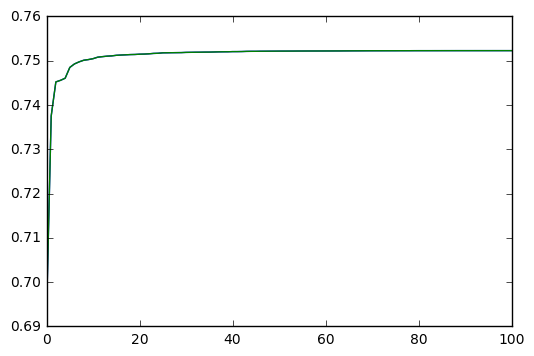

In [260]:
plt.plot(np.exp(-abaloneLinLogModel.getErrorTrace()))
plt.show()

It does appear that the linear logistic regression has reached a limit near 75% accuracy.

In [258]:
plt.plot(np.exp(-abaloneNNModel.getErrorTrace()))
plt.show()

Hm. This is still growing ... perhaps I was wrong about the trend ... let's try training to 2000 instead.

In [261]:
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[60,60], 2000])

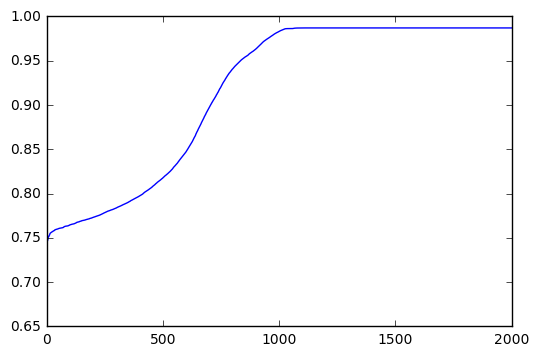

In [262]:
plt.plot(np.exp(-abaloneNNModel.getErrorTrace()))
plt.show()

Hm. It looks like there's a significant difference here from what I was expecting. Let's check the accuracy against the test partition.

In [263]:
evaluateNN(abaloneNNModel,abaloneXTest,abaloneTTest)

49.101796407185631

Whoops. That's unexpected ... overtrained perhaps?

In [267]:
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[60,60], 500])
evaluateNN(abaloneNNModel,abaloneXTest,abaloneTTest)

53.65269461077844

In [268]:
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[60,60], 750])
evaluateNN(abaloneNNModel,abaloneXTest,abaloneTTest)

53.053892215568865

In [272]:
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[60,60], 200])
evaluateNN(abaloneNNModel,abaloneXTest,abaloneTTest)

55.808383233532936

In [274]:
plt.plot(np.exp(-abaloneNNModel.getErrorTrace()))
plt.show()

It looks like there was some overtraining, but it also looks like I got unlucky in selecting training and test sets, since neither of these is anywhere near the 70-80% I was hoping for, but rather the worst case of the samples. let's look at the first hidden layer weight vectors.

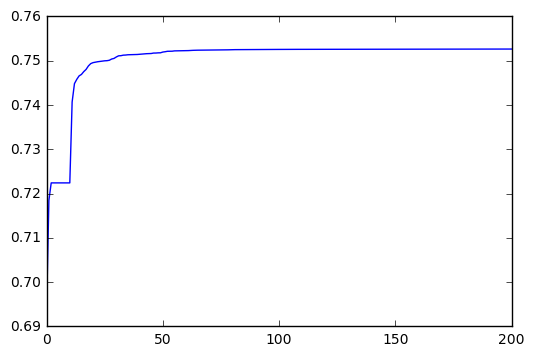

In [277]:
abaloneNNModel = trainNN(abaloneXTrain, abaloneTTrain, [[1], 200])
plt.plot(np.exp(-abaloneNNModel.getErrorTrace()))
plt.show()

27.0887412271 5.8860911441 1736.11111111


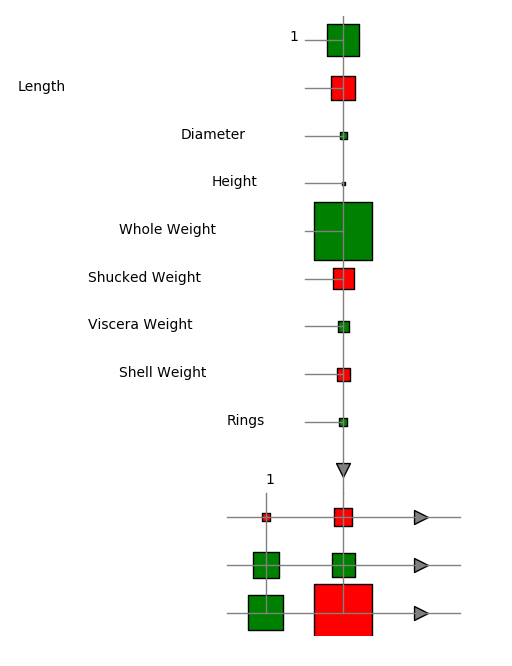

In [283]:
plt.figure(figsize=(6,8))
abaloneNNModel.draw(inputNames = abaloneNames)
plt.show()

As expected, the whole weight is the largest factor; in fact it is the only one smaller than the bias. It also only moderately impacts the first two outputs but heavily negatively impacts the third output, which likely hints at the identification of the infant gender.

Now let's look at the the LDA model. In particular let's examine the accuracy and the mu values it generated. 

In [313]:
evaluateLDA(abaloneLDAModel,abaloneXTest,abaloneTTest)

52.934131736526943

That's not great, but better than a random guess at least?

In [312]:
mus = abaloneLDAModel.mu
classes = ['male', 'female', 'infant']
print(' '*15, end='')
for name in abaloneNames:
    print("{:>10}".format(name[:5]), end='')
print()
for i, traits in enumerate(mus):
    print("{:<15}".format(classes[i]), end='')
    for trait in traits:
        print("{:>10.2f}".format(trait[0]), end='')
    print()

                    Lengt     Diame     Heigh     Whole     Shuck     Visce     Shell     Rings
male                 0.32      0.32      0.29      0.34      0.34      0.32      0.31      0.24
female               0.46      0.47      0.43      0.44      0.39      0.46      0.46      0.36
infant              -0.81     -0.83     -0.75     -0.82     -0.76     -0.81     -0.80     -0.62


These values tell me that it is harder to distinguish between male and female than it is to classify an infant. The magnitude of $\mu$ is much larger for infants. I've had trouble identifying exactly what this means in terms of the discriminating function, since it appears to have both a negative and positive role. 

In [319]:
P_X,Prtrain,_ = abaloneLDAModel.use(abaloneXTest)
ml.confusionMatrix(abaloneTTest,P_X,np.unique(abaloneTTest));

       1    2    3
    ------------------
 1 | 33.3 42.5 24.2   (306 / 306)
 2 | 34.5 49.4 16.1   (261 / 261)
 3 | 11.9  9.3 78.7   (268 / 268)


The confusion matrix tells the story I expected: While there is some confusion in the infant, it is typically confused with the smaller females rather than males. Males and females are frequently confused with eachother. In general, the model poorly classifies adult abalone but does a passable job of discriminating infants. It is probable that the classifier needs additional information to function at a useful level.

#### Cover Type
Cover type will be harder; it is a very large set of data. I will try smaller samples and try to find something reasonable rather than a more exhaustive search. To begin with, I begin with a linear logistic regression to develop a baseline.

In [321]:
coverLinLogParams = [
    [ [0], 10],
    [ [0], 100],
    [ [0], 300]
]
result = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, coverX,coverT, coverLinLogParams,
                                         nFolds=3, shuffle=True,verbose=False)
prettyPrintResults(result)

KeyboardInterrupt: 

A little further refinement ...

In [ ]:
coverLinLogParams = [
    [ [0], 50],
    [ [0], 100],
    [ [0], 150]
]
result = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, coverX,coverT, coverLinLogParams,
                                         nFolds=3, shuffle=True,verbose=False)
prettyPrintResults(result)

### Analysis and Comparison
In this section, we will be looking for

* clear explanations of each function;
* experiments with two different data sets with descriptions of the data;
* discussion of each result, including
  * accuracies as percent correctly classified,
  * best parameter values,
  * some analysis of each classification algorithm and how it is classifying the data by examining the $\mu$ values for LDA, and the first layer's weight values for the neural networks;
* and discuss which algorithm works best for each data set.